In [1]:
import tensorflow as tf
from utils import actomyosin_data, plot64
from model.autoencoder_3d_xy50_t8 import AE
from train_utils.autoencoder import AETrain, VAETrain, CVAETrain
import time
import argparse
from datetime import datetime
from packaging import version
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import tifffile
import os
import warnings
from itertools import cycle, islice

from skimage.transform import resize
from skimage.io import imsave, imread

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

2024-09-16 14:53:03.620921: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
net_type = 'simple'
latent_dim = 12
train_buf = 12000
batch_size = 900

model_ID = 'ACTO_AE_flow_123x_ld12_ntsimple_bs900_t4ps32_20240916'

# Create a new model instance
model = AE(latent_dim, net_type=net_type)

# Restore the weights
model.load_weights('./checkpoints/'+model_ID+'/')

2024-09-16 14:53:05.405262: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-09-16 14:53:05.407020: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-09-16 14:53:05.469523: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-16 14:53:05.469555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.99GiB deviceMemoryBandwidth: 938.86GiB/s
2024-09-16 14:53:05.469564: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-09-16 14:53:05.470566: I tensorflow/stream_executor/platf

In [8]:

data_dir = '/mnt/d/lding/actomyosin/data/VidS1_TopCell/FlowFrame_50pix'
patch_size = 50
time_segment = 8

filenames = [x for x in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, x)) and ('.tif' in x)]
filenames.sort()


for filename_ind in range(len(filenames)):
    filename = filenames[filename_ind] 
             
    alltest_img = tifffile.imread(os.path.join(data_dir,filename))

    alltest_img = alltest_img - alltest_img.min()
    alltest_img = alltest_img/alltest_img.max()
    
    movie_len = alltest_img.shape[0]   
    small_alltest_img = alltest_img[0:movie_len,0:patch_size,0:patch_size]
    
    if(filename_ind == 0):
        print(alltest_img.shape)
        time_seg_per_movie = movie_len-time_segment - 1 
        num_of_samples = len(filenames)*time_seg_per_movie
        alltest_images = np.zeros([num_of_samples, time_segment, patch_size, patch_size ])
        alltest_labels= np.zeros([num_of_samples])

       
    for ti in range(0,time_seg_per_movie):           
        alltest_images[filename_ind*time_seg_per_movie + ti,:,:,:] = small_alltest_img[ti:ti+time_segment,:,:]
        alltest_labels[filename_ind*time_seg_per_movie + ti] = int(filename[4:6]+str(ti).zfill(2)+'1')


alltest_images = alltest_images[0:min(len(filenames)*time_seg_per_movie,train_buf),:,:,:]

alltest_images = alltest_images.reshape(alltest_images.shape[0],time_segment, patch_size, patch_size, 1).astype('float32')

(61, 50, 50)


In [9]:
alltest_images_flip = alltest_images[:,:,::-1,::-1,:]

alltest_images = np.concatenate([alltest_images,alltest_images_flip])

alltest_labels = np.concatenate([alltest_labels,alltest_labels+100000])

In [10]:
TRAIN_BUF = train_buf
BATCH_SIZE = batch_size

alltest_dataset_image = tf.data.Dataset.from_tensor_slices(alltest_images).batch(BATCH_SIZE)
alltest_dataset_label = tf.data.Dataset.from_tensor_slices(alltest_labels).batch(BATCH_SIZE)
alltest_dataset = tf.data.Dataset.zip((alltest_dataset_image, alltest_dataset_label)).shuffle(TRAIN_BUF)

In [11]:
flag_sample = 1

for x_input, y_input in alltest_dataset:
    if flag_sample == 1:        
        z = model.encode(x_input)
        Z_array = z.numpy()
        flag_sample = 0
    else:
        z = model.encode(x_input)
        Z_array = np.concatenate((Z_array,z.numpy()), axis=0)
        

In [15]:
Z_array.shape[0]/52


40.0

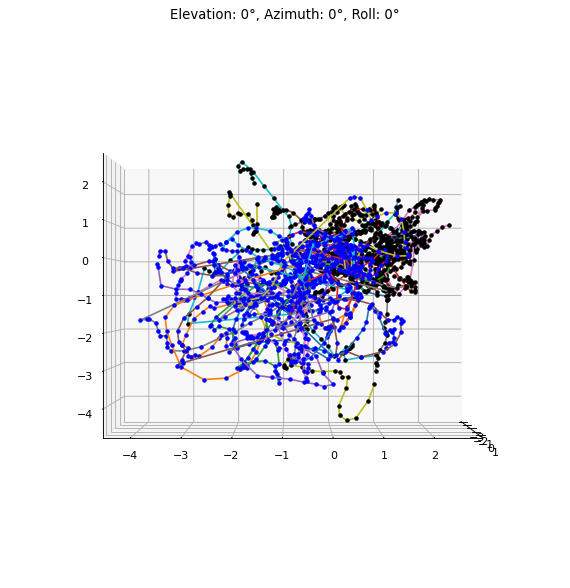

In [23]:

fig = plt.figure(figsize=(9,9), dpi=80)
ax = fig.add_subplot(projection='3d')
for i in range(20):
    ax.plot(Z_array[i*52:i*52+52, 0],Z_array[i*52:i*52+52, 1], Z_array[i*52:i*52+52, 2])
    ax.plot(Z_array[i*52:i*52+52, 0],Z_array[i*52:i*52+52, 1], Z_array[i*52:i*52+52, 2],'k.')
    
for i in range(20,40):
    ax.plot(Z_array[i*52:i*52+52, 0],Z_array[i*52:i*52+52, 1], Z_array[i*52:i*52+52, 2])
    ax.plot(Z_array[i*52:i*52+52, 0],Z_array[i*52:i*52+52, 1], Z_array[i*52:i*52+52, 2],'b.')
    

# Rotate the axes and update
for angle in range(0, 360*4 + 1, 10):
    # Normalize the angle to the range [-180, 180] for display
    angle_norm = (angle + 180) % 360 - 180

    # Cycle through a full rotation of elevation, then azimuth, roll, and all
    elev = azim = roll = 0
    if angle <= 360:
        elev = angle_norm
    elif angle <= 360*2:
        azim = angle_norm
    elif angle <= 360*3:
        roll = angle_norm
    else:
        elev = azim = roll = angle_norm

    # Update the axis view and title
    ax.view_init(elev, azim, roll)
    plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))
    plt.savefig('/mnt/d/lding/actomyosin/ACTO_xyz3D_flow123x_results/ACTO_AE_flow_123x_ld12_ntsimple_bs900_t4ps32_20240916/latent3d_rotate/'+'Elev%dAzim%dRoll%d.jpg'% (elev, azim, roll))


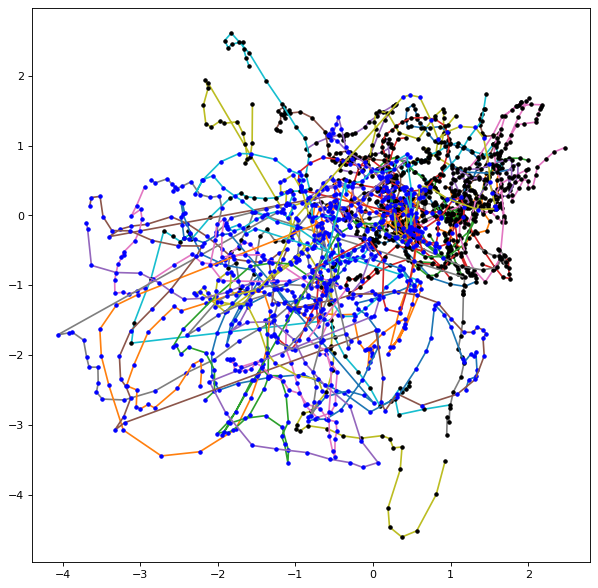

In [21]:

fig = plt.figure(figsize=(9,9), dpi=80)
ax = fig.add_subplot()
for i in range(20):
    ax.plot(Z_array[i*52:i*52+52, 1],Z_array[i*52:i*52+52, 2])
    ax.plot(Z_array[i*52:i*52+52, 1],Z_array[i*52:i*52+52, 2],'k.')

for i in range(20,40):
    ax.plot(Z_array[i*52:i*52+52, 1],Z_array[i*52:i*52+52, 2])
    ax.plot(Z_array[i*52:i*52+52, 1],Z_array[i*52:i*52+52, 2],'b.')
    

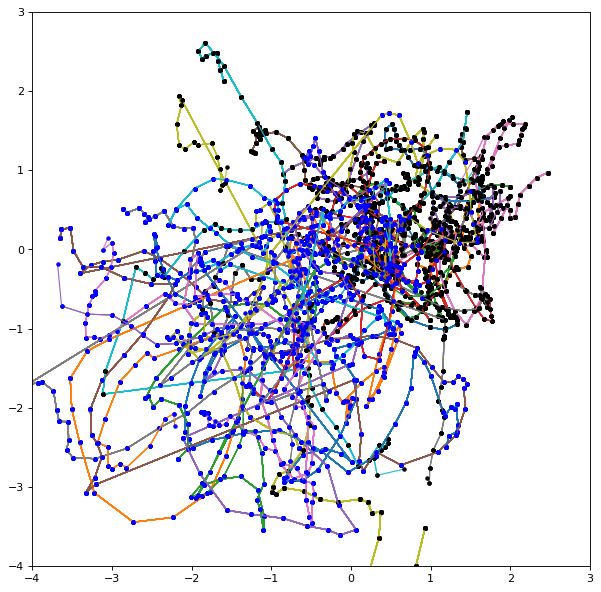

In [45]:
fig = plt.figure(figsize=(9,9), dpi=80)
ax = fig.add_subplot()
for j in range(0,52):
    for i in range(20):
        ax.plot(Z_array[i*52:i*52+j, 1],Z_array[i*52:i*52+j, 2],linewidth=1)
        ax.plot(Z_array[i*52:i*52+j, 1],Z_array[i*52:i*52+j, 2],'k.')

    for i in range(20,40):
        ax.plot(Z_array[i*52:i*52+j, 1],Z_array[i*52:i*52+j, 2],linewidth=1)
        ax.plot(Z_array[i*52:i*52+j, 1],Z_array[i*52:i*52+j, 2],'b.')

    ax.set_xlim(-4,3)
    ax.set_ylim(-4,3)
    plt.savefig('/mnt/d/lding/actomyosin/ACTO_xyz3D_flow123x_results/ACTO_AE_flow_123x_ld12_ntsimple_bs900_t4ps32_20240916/trac/'
            +'traj_t%d'% (j))
    